<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/EL2O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
# IMAGE_SHAPE = [28, 28, 1]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Simple recovery of a multivariate Gaussian by taking gradients at samples; this is **EL2O** 'by hand'

In [0]:
tf.reset_default_graph()


batch_size  = 2#256
hidden_size = 4


sample_size = tf.placeholder_with_default(500,shape=[])


ini_val = np.ones((batch_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
mu_t    = tf.constant(np.zeros((batch_size,hidden_size), dtype=np.float32))
                   
sigma_t = tf.constant(ini_val)

sigma_t2 = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_t), transform=tf.nn.softplus)


approx_posterior2 = tfd.MultivariateNormalTriL(loc=mu_t,scale_tril=sigma_t2, name='posterior2')

z2                = approx_posterior2.sample()

big_sample        = approx_posterior2.sample(sample_size)

xx                = tf.Variable(z2)

p_of_z            = -approx_posterior2.log_prob(xx)

dpdz              = tf.gradients(p_of_z, xx) 

dpdz              = tf.gather(dpdz, 0)

hess              = tf.hessians(p_of_z,xx)

hess              = tf.gather(hess, 0)

hess2             = tf.reduce_sum( hess, axis = 2 )

eigen             = tf.linalg.eigh(hess2)

sigma_new         = tf.linalg.inv(hess2)
#sigma_new         = (sigma_new+tf.linalg.transpose(sigma_new))/2.

eigen2            = tf.linalg.eigh(sigma_new)

mu_new            = -tf.einsum('ijk,ik->ij', sigma_new,dpdz)+xx

sigma_ch          = tf.linalg.cholesky(sigma_new)

approx_posterior3 = tfd.MultivariateNormalFullCovariance(loc=mu_new, covariance_matrix=sigma_new)


z3                = approx_posterior3.sample(sample_size)

check if we recover correct mean and covariances:

In [224]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#covariances agree
res, res2= sess.run([sigma_t2, sigma_ch])
print(res,res2)

#means agree
mu, mu_n= sess.run([mu_t,mu_new])
print(mu,mu_n)

[[[1.3132616 0.        0.        0.       ]
  [1.        1.3132616 0.        0.       ]
  [1.        1.        1.3132616 0.       ]
  [1.        1.        1.        1.3132616]]

 [[1.3132616 0.        0.        0.       ]
  [1.        1.3132616 0.        0.       ]
  [1.        1.        1.3132616 0.       ]
  [1.        1.        1.        1.3132616]]] [[[1.3132615  0.         0.         0.        ]
  [1.         1.3132614  0.         0.        ]
  [0.9999999  0.99999964 1.3132616  0.        ]
  [0.9999999  0.99999964 0.9999999  1.3132617 ]]

 [[1.3132615  0.         0.         0.        ]
  [1.         1.3132614  0.         0.        ]
  [0.9999999  0.99999964 1.3132616  0.        ]
  [0.9999999  0.99999964 0.9999999  1.3132617 ]]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]] [[-2.3841858e-07  8.3446503e-07  4.7683716e-07  2.3841858e-07]
 [ 2.3841858e-07 -1.7881393e-07 -9.5367432e-07 -4.7683716e-07]]


and plot samples from the distributions

(array([  2.,   6.,   5.,   4.,   6.,   8.,   7.,  22.,  23.,  27.,  30.,
         39.,  58.,  67.,  75., 107., 113., 131., 138., 153., 197., 194.,
        208., 210., 249., 227., 206., 205., 180., 171., 152., 160., 101.,
        107.,  98.,  46.,  59.,  47.,  36.,  41.,  18.,  12.,  12.,   7.,
         13.,  10.,   8.,   2.,   1.,   2.]),
 array([-5.96197891, -5.7198505 , -5.47772209, -5.23559368, -4.99346527,
        -4.75133686, -4.50920845, -4.26708004, -4.02495163, -3.78282322,
        -3.54069481, -3.2985664 , -3.05643799, -2.81430958, -2.57218117,
        -2.33005276, -2.08792435, -1.84579594, -1.60366753, -1.36153912,
        -1.11941071, -0.8772823 , -0.63515388, -0.39302547, -0.15089706,
         0.09123135,  0.33335976,  0.57548817,  0.81761658,  1.05974499,
         1.3018734 ,  1.54400181,  1.78613022,  2.02825863,  2.27038704,
         2.51251545,  2.75464386,  2.99677227,  3.23890068,  3.48102909,
         3.7231575 ,  3.96528591,  4.20741432,  4.44954273,  4.69167114,
 

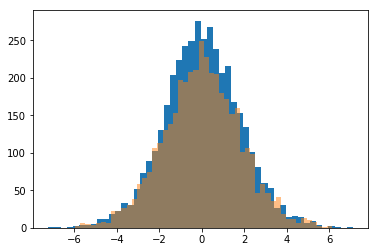

In [225]:
res, res2= sess.run([big_sample,z3])
plt.hist(res.flatten(),bins=50)
plt.hist(res2.flatten(),alpha=0.5,bins=50)

now let's see if we can automize this by minimizing the **EL2O**

In [0]:
tf.reset_default_graph()


batch_size  = 2
hidden_size = 4

lr          = tf.placeholder_with_default(0.001,shape=[])
sample_size = tf.placeholder_with_default(500,shape=[])


# this is the true distribution
ini_val = np.ones((batch_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
mu_true    = tf.constant(np.zeros((batch_size,hidden_size), dtype=np.float32))                  
sigma_true = tf.constant(ini_val)
sigma_t2 = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_true), transform=tf.nn.softplus)

true_posterior = tfd.MultivariateNormalTriL(loc=mu_true,scale_tril=sigma_t2, name='trueposterior')


# this is going to be our approximation of the posterior
ini_val      = 1.2*np.ones((batch_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
mu_approx    = tf.Variable(initial_value=0.5*np.ones((batch_size,hidden_size), dtype=np.float32))                  
sigma_approx = tf.Variable(ini_val)
sigma_approx2= tfd.matrix_diag_transform(tfd.fill_triangular(sigma_approx), transform=tf.nn.softplus)

approx_posterior = tfd.MultivariateNormalTriL(loc=mu_approx,scale_tril=sigma_approx2, name='approxposterior')

z                = approx_posterior.sample()

xx               = tf.Variable(z)

p_of_z           = -approx_posterior.log_prob(xx)
pt_of_z          = -true_posterior.log_prob(xx)

dpdz              = tf.gradients(p_of_z, xx) 

dpdz              = tf.gather(dpdz, 0)

dptdz             = tf.gradients(pt_of_z, xx) 

dptdz             = tf.gather(dptdz, 0)

hess              = tf.hessians(p_of_z,xx)

hess              = tf.gather(hess, 0)

hess2             = tf.reduce_sum( hess, axis = 2 )

#sets values that are double to zero
lowt              = tf.matrix_band_part(hess2, -1, 0)

hesst             = tf.hessians(pt_of_z,xx)

hesst             = tf.gather(hesst, 0)

hesst2            = tf.reduce_sum( hesst, axis = 2 )

lowt2             = tf.matrix_band_part(hesst2, -1, 0)

EL2O              = tf.reduce_sum(tf.math.square(dpdz-dptdz))+tf.reduce_sum(tf.math.square((lowt-lowt2)))



In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op    = optimizer.minimize(EL2O,var_list=[mu_approx,sigma_approx])

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [329]:
lrate= 0.05
for ii in range(2000):
  _, loss  = sess.run([opt_op, EL2O], feed_dict={lr:lrate})
print(loss)

6.9867085e-05


this seems to work, too, but at some additional cost, could probably optimize the optimization with second derivatives...

In [330]:
### seems to be working too!
res, res2, mut, sigmat = sess.run([mu_approx,sigma_approx2,mu_true,sigma_t2])
print(res,mut)
print(res2,sigmat)

[[0.00743369 0.01199255 0.01502631 0.01653728]
 [0.08273391 0.1304898  0.1697108  0.18788718]] [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[[1.3111266  0.         0.         0.        ]
  [0.9946116  1.3116595  0.         0.        ]
  [0.99309546 0.99669147 1.3126882  0.        ]
  [0.992199   0.9959294  0.99890435 1.3131263 ]]

 [[1.3308675  0.         0.         0.        ]
  [1.0444174  1.3248684  0.         0.        ]
  [1.0615145  1.029821   1.3208656  0.        ]
  [1.070637   1.0374932  1.0152241  1.3151367 ]]] [[[1.3132616 0.        0.        0.       ]
  [1.        1.3132616 0.        0.       ]
  [1.        1.        1.3132616 0.       ]
  [1.        1.        1.        1.3132616]]

 [[1.3132616 0.        0.        0.       ]
  [1.        1.3132616 0.        0.       ]
  [1.        1.        1.3132616 0.       ]
  [1.        1.        1.        1.3132616]]]


start with a Laplace approximation

In [0]:
tf.reset_default_graph()


batch_size  = 2
hidden_size = 4

lr          = tf.placeholder_with_default(0.001,shape=[])
sample_size = tf.placeholder_with_default(500,shape=[])


# this is the true distribution
ini_val = np.ones((batch_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
mu_true    = tf.constant(np.zeros((batch_size,hidden_size), dtype=np.float32))                  
sigma_true = tf.constant(ini_val)
sigma_t2 = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_true), transform=tf.nn.softplus)

true_posterior = tfd.MultivariateNormalTriL(loc=mu_true,scale_tril=sigma_t2, name='trueposterior')


# this is going to be our approximation of the posterior

mu_approx    = tf.Variable(initial_value=0.5*np.ones((batch_size,hidden_size), dtype=np.float32))       

# get hessian at mean of approximate posterior
x_           = tf.Variable(mu_approx)
p_mu         = -true_posterior.log_prob(x_)

hessl        = tf.hessians(p_mu,x_)

hessl        = tf.gather(hessl, 0)

hessl        = tf.reduce_sum(hessl, axis = 2 )

sigmal       = tf.linalg.inv(hessl)

chol         = tf.linalg.cholesky(sigmal)


tf.stop_gradient(sigma_approx)
# and use the derived sigma as initial sigma -> Laplace approximation
sigma_approx = tf.Variable(chol)

approx_posterior = tfd.MultivariateNormalTriL(loc=mu_approx,scale_tril=sigma_approx, name='approxposterior')

z                = approx_posterior.sample()

xx               = tf.Variable(z)

p_of_z           = -approx_posterior.log_prob(xx)
pt_of_z          = -true_posterior.log_prob(xx)

dpdz              = tf.gradients(p_of_z, xx) 

dpdz              = tf.gather(dpdz, 0)

dptdz             = tf.gradients(pt_of_z, xx) 

dptdz             = tf.gather(dptdz, 0)

hess              = tf.hessians(p_of_z,xx)

hess              = tf.gather(hess, 0)

hess2             = tf.reduce_sum( hess, axis = 2 )

#sets values that are double to zero
lowt              = tf.matrix_band_part(hess2, -1, 0)

hesst             = tf.hessians(pt_of_z,xx)

hesst             = tf.gather(hesst, 0)

hesst2            = tf.reduce_sum( hesst, axis = 2 )

lowt2             = tf.matrix_band_part(hesst2, -1, 0)

EL2O              = tf.reduce_sum(tf.math.square(dpdz-dptdz))+tf.reduce_sum(tf.math.square((lowt-lowt2)))



In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op    = optimizer.minimize(EL2O,var_list=[mu_approx,sigma_approx])

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [343]:
#starting at laplace in this case, gives lower EL2O
lrate= 0.05
for ii in range(2000):
  _, loss  = sess.run([opt_op, EL2O], feed_dict={lr:lrate})
print(loss)

8.412061e-06


In [344]:
### seems to be working too!
res, res2, mut, sigmat = sess.run([mu_approx,sigma_approx,mu_true,sigma_t2])
print(res,mut)
print(res2,sigmat)

[[0.00913437 0.01422298 0.01857121 0.02040558]
 [0.00597881 0.009539   0.01204131 0.01334246]] [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[[1.3110282  0.         0.         0.        ]
  [0.99377674 1.3112942  0.         0.        ]
  [0.9918645  0.99556506 1.3124146  0.        ]
  [0.99038756 0.99523526 0.99783605 1.3132738 ]]

 [[1.3117437  0.         0.         0.        ]
  [0.9963134  1.3122506  0.         0.        ]
  [0.9949883  0.9976562  1.3127372  0.        ]
  [0.9943018  0.99709946 0.9989153  1.3131356 ]]] [[[1.3132616 0.        0.        0.       ]
  [1.        1.3132616 0.        0.       ]
  [1.        1.        1.3132616 0.       ]
  [1.        1.        1.        1.3132616]]

 [[1.3132616 0.        0.        0.       ]
  [1.        1.3132616 0.        0.       ]
  [1.        1.        1.3132616 0.       ]
  [1.        1.        1.        1.3132616]]]
